In [427]:
import os,re
import time,pickle
from tqdm import *
from os.path import expanduser
import sklearn
import matplotlib.pylab as plt
%matplotlib inline

# Introduction

The AGU conference is hold each year in San Francisco a few weeks before christmas.

With nearly 24,000 attendees, AGU Fall Meeting is the largest Earth and space science meeting in the world. As such, it is also a great dataset to study trends in the geoscience community. In the following, I use the papers contribution in the year 2015 and 2014 to find out some hidden structure in the abstracts.
The aim is two fold:

- For a given contribution, identify a list of similar contribution in the database
- For the contributions of a particular authors, identify a list of potential collaborators with names, adress and institute displayed on a map.

The method is greatly inspired from [Amir Amini](https://www.kaggle.com/amirhamini/d/benhamner/nips-2015-papers/find-similar-papers-knn/notebook) and [brandonmrose](http://brandonrose.org/clustering).

# Data preprocessing 

## Scrapping the AGU website 

The scripts used to scrap the [AGU wesbsite](https://fallmeeting.agu.org/2015/) as well as the resulting data are stored on this [repo](https://github.com/cthorey/agu_data) if you want to reproduce the following by yourself.

In [428]:
home = expanduser('~')
os.chdir(os.path.join(home,'Documents','repos','agu_data','agu_data'))
from Data_Utils import *

data = get_all_data('agu2015')
sources = [df for df in data if (''.join(df.title) != "") and (df.abstract != '')]
raw_abstracts = [df.abstract for df in sources]
raw_titles = [' '.join(df.title) for df in sources]
sessions = [f.session for f in sources]
sections = [f.section for f in sources]
authors = [', '.join(f.authors.keys()) for f in sources]

def first_clean_title(text):
    if text.split(' ')[-1] == '(Invited)':
        text = ' '.join(text.split(' ')[:-1])
    return text

def first_clean_abstract(text):
    if text.split('\n')[0].split(' ')[0] =='ePoster':
        text = ' '.join(text.split('\n')[1:])
    return text

raw_abstracts = map(first_clean_abstract,raw_abstracts)
raw_titles = map(first_clean_title,raw_titles)

AGU abstract are short, $\sim 300$ words and looks like that

In [429]:
idx = 300
print '\n The title of this paper is : \n %s'%(titles[idx])
print '\n The corresponding abstract is :\n %s'%(abstracts[idx])


 The title of this paper is : 
  Slow Climate Velocities in Mountain Streams Impart Thermal Resistance to Cold-Water Refugia Across the West

 The corresponding abstract is :
 Mountain streams provide important headwater refugia for native fish, amphibians, and other cold-water fauna globally. Although the well documented existence of such refugia indicates some level of resistance to ongoing environmental change, stream warming associated with climate change raises questions about their future persistence. Moreover, evidence exists that air temperatures are warming faster at higher elevations, and some stream temperature models predict that cold streams associated with snowmelt hydrologies will be most sensitive to air temperature increases (i.e. high ratio of stream  C:air  C). Here, we estimate stream sensitivities to climate forcing using long-term monitoring records from 927 sites across the topographically complex northwestern U.S. Sensitivity values are combined with high-resol

We first remove extra text in the abstract (eposter) and (Invited) + convert unicode characters

In [430]:
import unicodedata
def clean_title(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii','ignore')
    text = text.replace('\n', ' ')
    return text

def clean_abstract(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii','ignore')
    text = text.replace('\n', ' ')
    return text

titles = map(clean_title,raw_titles)
abstracts = map(clean_abstract,raw_abstracts)

In [431]:
idx = 300
print '\n The title of this paper is : \n %s'%(titles[idx])
print '\n The corresponding abstract is :\n %s'%(abstracts[idx])


 The title of this paper is : 
  Slow Climate Velocities in Mountain Streams Impart Thermal Resistance to Cold-Water Refugia Across the West

 The corresponding abstract is :
 Mountain streams provide important headwater refugia for native fish, amphibians, and other cold-water fauna globally. Although the well documented existence of such refugia indicates some level of resistance to ongoing environmental change, stream warming associated with climate change raises questions about their future persistence. Moreover, evidence exists that air temperatures are warming faster at higher elevations, and some stream temperature models predict that cold streams associated with snowmelt hydrologies will be most sensitive to air temperature increases (i.e. high ratio of stream  C:air  C). Here, we estimate stream sensitivities to climate forcing using long-term monitoring records from 927 sites across the topographically complex northwestern U.S. Sensitivity values are combined with high-resol

## Tokenizing and stemming

The texts above cannot be fed directly into an algorithm to identify pattern within the corpus.
Instead, some form of vectorization have to be used.

A bag of words method is generally used in that purpose. In such a method, each document is first broken into unbreakable tokens and, in this method:

- each individual token occurrence frequency (normalized or not) is treated as a feature.
- the vector of all the token frequencies for a given document is considered a multivariate sample.

In the following, I build a function based on the library **nltk** to broke a documents into its most basic form, a list of stems.

To do so, 

- We first broke each documents in sentence and the words
- Remove all numeric, ponctuations with the module **re**
- Remove stowords from the tokens
- Stem each resulting tokens

In [432]:
import nltk

# Load SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token.lower())
    filtered_tokens = [token for token in filtered_tokens if token not in stopwords]
    stems = map(stemmer.stem,filtered_tokens)
    return map(str,stems)

# tf-idf representation 

Using the **tokenize_and_stem** function, we can then break each document in tokens and vectorize it. The vectorization will result in a matrix whom 

- each line is a text document of the corpus
- each column represent a token from the corpus
- a specific value represent the number of occurences of a particular token in a particular document

While **sklearn** provides a class **CountVectorizer** which can be used to form such a matrix, this representation often put to much weights on common words of the corpus, i.e. words like *the*, *a* in english. While this can be interesting in some situations, we would like to put more weight on words that make each abstract specific for our application.

One way to do this is to use a **Tf-idf** normalization to re-weiht each value in the matrix by the frequency of the token in the whole corpus. **Tf** means term-frequency while **tf–idf** means term-frequency times inverse document-frequency.

This normalization is implemented by the **TfidfTransformer** class of sklearn and is used in the following.

Main parameters:

- max_df : When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold
- min_df : When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold
- ngram_range : Range of n-gram to consider. Bi-gram and Three gram like floor fractured craters is preserved

## Small sub-routine

In [433]:
# Small routine to save the idf class and the resulting matrix.
model_saved = os.path.join(home,'Documents','repos','agu_data','Notebook','Models')
from sklearn.externals import joblib
def save_idf(folder,idf_vectorizer,idf_matrix):
    joblib.dump(idf_vectorizer,os.path.join(folder,'idf_vectorizer.pkl'))
    joblib.dump(idf_matrix,os.path.join(folder,'idf_matrix.pkl'))
    
def open_idf(folder):
    idf_vectorizer = joblib.load(os.path.join(folder,'idf_vectorizer.pkl'))
    idf_matrix = joblib.load(os.path.join(folder,'idf_matrix.pkl'))
    return idf_vectorizer, idf_matrix

## Titles 

In [434]:
from sklearn.feature_extraction.text import TfidfVectorizer

folder_titles = os.path.join(model_saved,'tfidf','titles')
recompute = False
if len(os.listdir(folder_titles)) == 0 or recompute:
    print 'Create files'
    titles_tfidf_vectorizer = TfidfVectorizer(analyzer = 'word',
                                   max_df=0.95, 
                                   max_features=200000, 
                                   min_df=0.001, 
                                   stop_words=stopwords,
                                   use_idf=True, 
                                   tokenizer=tokenize_and_stem,
                                   lowercase = True,
                                   ngram_range=(1,3))
    %time idf_titles = titles_tfidf_vectorizer.fit_transform(titles)
    save_idf(folder_titles,titles_tfidf_vectorizer,idf_titles)
else:
    print 'Load files'
    %time titles_tfidf_vectorizer, idf_titles = open_idf(folder_titles)

Create files
CPU times: user 20.6 s, sys: 344 ms, total: 21 s
Wall time: 20.9 s


## Abstracts 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
folder_abstracts = os.path.join(model_saved,'tfidf','abstracts')

recompute = False
if len(os.listdir(folder_titles)) == 0 or recompute:
    print 'Create files'
    abstracts_tfidf_vectorizer = TfidfVectorizer(analyzer = 'word',
                                   max_df=0.9, 
                                   max_features=200000, 
                                   min_df=0.01, 
                                   stop_words=stopwords,
                                   use_idf=True, 
                                   tokenizer=tokenize_and_stem,
                                   lowercase = True,
                                   ngram_range=(1,3))
    %time idf_abstracts = abstracts_tfidf_vectorizer.fit_transform(abstracts)
    save_idf(folder_abstracts,abstracts_tfidf_vectorizer,idf_abstracts)
else:
    print 'Load files'
    %time abstracts_tfidf_vectorizer, idf_abstracts = open_idf(folder_abstracts)

Load files
CPU times: user 28.5 s, sys: 1.27 s, total: 29.8 s
Wall time: 30.2 s


## Making sense of the tf-idf resulting arrays 

In [435]:
import pandas as pd
import numpy as np

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return 
        them with their corresponding feature names.'''
    
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [436]:
idx = 6339
top_tfidf_feats(np.squeeze(idf_abstracts[idx].toarray()),abstracts_tfidf_vectorizer.get_feature_names(),5)

,feature,tfidf
0,intrus,0.595818
1,deform,0.223510
2,magmat,0.204524
3,regim,0.180677
4,predict,0.167379


In [437]:
idx = 6339
top_tfidf_feats(np.squeeze(idf_titles[idx].toarray()),titles_tfidf_vectorizer.get_feature_names(),5)

,feature,tfidf
0,general,0.538683
1,intrus,0.511470
2,magmat,0.465001
3,shallow,0.427042
4,model,0.222773


# Finding similar document 

Now, we have a representation, we can try to look for similar documents based on their degree of proximity. 

**Sklearn** offers a class NearestNeighboors that can find the closest document in our embedding space given a specific metrics.

In [438]:
from sklearn.neighbors import NearestNeighbors

In [439]:
import sklearn
import matplotlib.pylab as plt
%matplotlib inline

## Influence of the chose metrics 

The NearestNeighbors class let us choose among many different metrics to solve the problem of finding good neightboors.

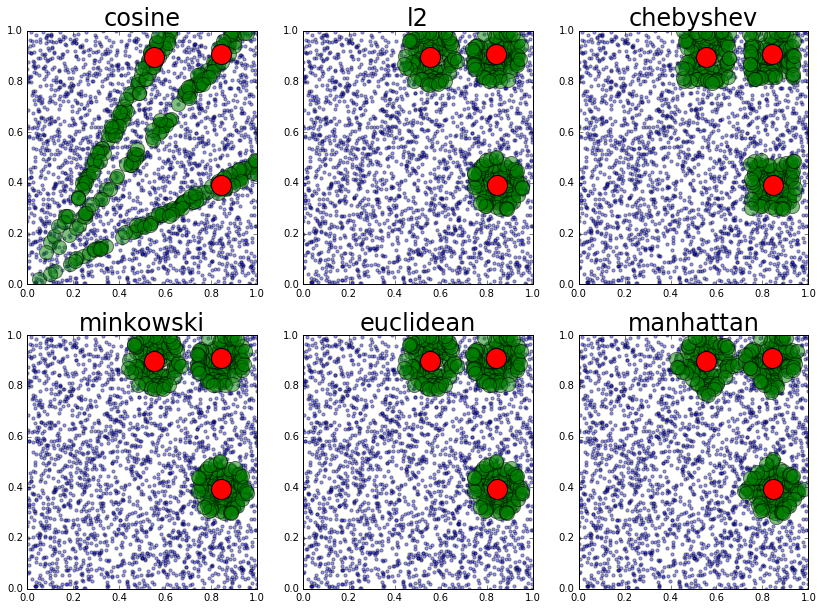

In [440]:
figure = plt.figure(figsize = (14,10))
ax1 = plt.subplot(231); ax2 = plt.subplot(232)
ax3 = plt.subplot(233); ax4 = plt.subplot(234)
ax5 = plt.subplot(235); ax6 = plt.subplot(236)

metrics = ['cosine', 'l2', 'chebyshev', 'minkowski','euclidean','manhattan']
axs = zip([ax1,ax2,ax3,ax4,ax5,ax6],metrics)
points = np.random.rand(6).reshape(3,2)
X = np.random.rand(5000).reshape((2500,2))

for ax, metric in axs:
    
    ax.set_title(metric,fontsize = 24)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

    # Data
    ax.scatter(X[:,0],X[:,1],marker = 'o',s = 10,alpha = 0.4)

    # Nearestneightbords
    nb = NearestNeighbors(n_neighbors=200,
                             algorithm='brute',
                             metric = metric)
    nb.fit(X)

    # Points to find the neigboors
    ax.scatter(points[:,0],points[:,1],marker='o',s = 400,c = 'r',zorder= 2)
    distance, idxs = nb.kneighbors(points,100,return_distance= True)

    for i in range(points.shape[0]):
        idx = idxs[i,:]
        near_points = X[idx,:]
        ax.scatter(near_points[:,0],near_points[:,1],marker = 'o',c = 'g',s = 200,alpha = 0.5,zorder= 1)

As seen above in a cartesian space:

- The chebyshev and the manhattan metrics tend to select the point in a square
- Other metrics, except the case of cosine, tends to prefere select point within a certain radius.

While the intution we developed here might not hold in the ~2000 dimensions manifold in which the tf-idf lives, I don't think the choice in the metrics is clearly the relevant parameter for our pupose. In particula, it should have only minor effects on the relevant character of the returns documents. In the following, we'll use the standard euclidean distance. 



## Abstract based recommendation

Let firs focus on the abstract corpus to base our recommendation system

In [441]:
nearest = NearestNeighbors(n_neighbors=200,
                           algorithm='auto',
                           metric = 'euclidean')
nearest.fit(idf_abstracts)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=200, p=2, radius=1.0)

To begin with, I'm going to recommend contributions on my proper contributions. This give me a sensible way to know it the recommendation are relevant or not. 

We first need, to develop a function which take as input a name and return a list of contributions index.

In [442]:
def name_to_idx(name):
    ''' From an authors, return the list of contributions '''
    contrib = [f for f in sources if name in f.authors.keys()]
    return [sources.index(elt) for elt in contrib]
    
idxs = name_to_idx('Clement Thorey')

Then, we can retrieve the closest matches for each contribution. For instance, looking at the first 10 closest document of my first contribution gives:

In [584]:
def print_result(recom, verbose):
    ''' Detail printing of the recommendation 
    
    Args:
        recom : Dataframe of the recommendation
        verbose: Degree of verbosity
            - 0: no printing
            - 1: print the titles
            - >1: print the authors and the abstracts
            - >2: print more than 2 recommendations
    '''
    for i, row in recom.iterrows():
        if verbose <3:
            if i>2:
                break
        if i == 0:
            if verbose>0:
                print 'The recommendation is based on the contribution: %s \n'%(row.title)
            if verbose >1:
                print 'of %s\n'%(row.authors)
                print 'The abstract is: \n \n%s \n\n'%(row.abstract)
        else:
            if verbose >0:
                print 'The recommendation number %d is: %s\n'%(i,row.title)
            if verbose >1:
                print 'of %s\n'%(row.authors)
                print 'The abstract is: \n \n%s \n\n'%(row.abstract)
        

def idx_to_recom(index, n_neightboor = 20, based_on ='abstracts', verbose = 0):
    ''' Return a list of recommendation for the corresponding index
    
    Args:
        index : index of the contribution to look at
        n_neightboor : Number of neightboor to return
        based_on : Base the recommendation on the abstract or the titles ?
        verbose : Degree of verbosity for the return
        
    Returns:
        A size n_neightboor dataframe of the recommendation
        
    '''
    base = {'abstracts': idf_abstracts, 'titles': idf_titles}
    nearest = NearestNeighbors(n_neighbors=200,
                               algorithm='brute',
                               metric = 'cosine')
    
    idf_matrix = base[based_on]
    nearest.fit(idf_matrix)
    distances ,indices = nearest.kneighbors(X = idf_matrix[index],
                                            n_neighbors = n_neightboor,
                                            return_distance=True)
    recom_index = indices[0,:]
    recom = np.vstack((range(len(recom_index)),
                       np.array(raw_titles)[recom_index],
                       np.array(raw_abstracts)[recom_index],
                       np.array(sections)[recom_index],
                       np.array(sessions)[recom_index],
                       np.array(authors)[recom_index],
                      ))
    recom = pd.DataFrame(recom.T,columns = ['Order','title','abstract','section','session','authors'])
    print_result(recom, verbose)
    return recom
    
def idx_to_collaborators(index, n_neightboor = 20, based_on ='abstracts', verbose =0):
    ''' Return a list of potential collaborator for the corresponding index
    
    Args:
        index : index of the contribution to look at.
        n_neightboor : Number of recommendations to consider.
        based_on : Base the recommendation on the abstract or the titles ?
        verbose : Degree of verbosity for the return.
        
    Returns:
        A list of potential authors that work in similar topic.
        
    '''
    recom = idx_to_recom(index, n_neightboor , based_on,verbose)
    auths = [f.strip() for f in reduce(lambda x,y:x+','+y,list(recom.authors)).split(',')]
    return auths
    

In [603]:
recom = idx_to_recom(idxs[1],n_neightboor=30, based_on= 'titles',verbose =1)

The recommendation is based on the contribution:  A General Model for Shallow Magmatic Intrusions 

The recommendation number 1 is:  A generalized quasi-geostrophic model of thermal convection

The recommendation number 2 is:  Characteristics of Earthquakes Induced by Shallow and Deep Crustal Dike Intrusions



In [604]:
for elt in recom.title:
    print elt

 A General Model for Shallow Magmatic Intrusions
 A generalized quasi-geostrophic model of thermal convection
 Characteristics of Earthquakes Induced by Shallow and Deep Crustal Dike Intrusions
 Modeling of Magnetic Anomalies Associated with Magmatic Intrusions Away from the Guaymas Basin Rift, Gulf of California
 Periodicity of Kı̄lauea’s Dike Intrusions
 How to build a mid-crustal intrusive suite  geologic mapping, U-Pb geo-/thermochronology, and thermal modeling of the Bergell Intrusion, Central Alps
 Petrological evidence for non-linear increase of magmatic intrusion rates before eruption at open vent mafic volcanoe
 Interactive Modelling of Salinity Intrusion in the Rhine-Meuse Delta
 Modeling Saltwater Intrusion in Highly Heterogeneous Coastal Aquifers
 Yingmailai Granitic Intrusion in the Southern Tianshan：Magnetite-series or Ilmenite-series?
 Crustal Strain Patterns in Magmatic and Amagmatic Early Stage Rifts  Border Faults, Magma Intrusion, and Volatiles
 Magmatic differentiat

In [578]:
nearest = NearestNeighbors(n_neighbors=200,
                        algorithm='brute',
                        metric = 'cosine')
nearest.fit(idf_titles)
distances ,indices = nearest.kneighbors(idf_titles[idxs[1]], 90 ,return_distance=True)
print indices

[[ 6339  1534 11668 19566  9367 17347 17015 20229 15864 10044  1667 18223
  16769  7563  6483  3424  7355   918 21618 11202 20304  8185  8566 12010
   9805 20685  9456  7332 16859 16494  7415  5118  1747 11661 14161  4919
   4431  9155  2174 11499 15218 15163 21135   453  7631  1104  9627   740
   5100  4765 12251  8798 17312 10766 21595  4283  4207  1682 16773 15123
  13612  4547 18525   303 10637    95 13015 13802  8470  4441 10795  3741
   8156  3963 16169 17990 16055  4715 13382  6513    48 20478  6488 17826
   3629 10652 13549 13888 15835 16743]]


In [579]:
distances

array([[ 0.        ,  0.58617844,  0.59856246,  0.59862577,  0.62100956,
         0.63807853,  0.67262342,  0.6742981 ,  0.68145727,  0.68348787,
         0.68520866,  0.6923834 ,  0.69546493,  0.69828666,  0.70074734,
         0.70176978,  0.70525497,  0.70945759,  0.71132519,  0.71141883,
         0.71554491,  0.71564756,  0.72057566,  0.72266139,  0.72348757,
         0.72614606,  0.7289623 ,  0.73083534,  0.73099781,  0.73136253,
         0.73149087,  0.73299255,  0.73403062,  0.73612105,  0.73648862,
         0.73879071,  0.73906206,  0.74543359,  0.74563581,  0.75023869,
         0.75251382,  0.75354924,  0.75488972,  0.7561237 ,  0.7568193 ,
         0.76042993,  0.76072713,  0.7609645 ,  0.76203046,  0.76349246,
         0.76444446,  0.76467784,  0.76641757,  0.76651136,  0.76736535,
         0.77096055,  0.77194425,  0.77203305,  0.77310653,  0.7769834 ,
         0.77722688,  0.77722688,  0.77722688,  0.77722688,  0.77746612,
         0.77773367,  0.77902111,  0.78229752,  0.7

In [ ]:
df

In [563]:
indices[0,:5]

array([ 6339,   463,  4981, 12594,  2628])

For instance, based on my contribution on **shallow magmatic intrusions**, the neightboor class tell me to check out :

In [444]:
recom = idx_to_recom(idxs[1], verbose =1)

The recommendation is based on the contribution:  A General Model for Shallow Magmatic Intrusions 

The recommendation number 1 is:  Periodicity of Kı̄lauea’s Dike Intrusions

The recommendation number 2 is:  Floor-Fractured Craters through Machine Learning Methods



In [446]:
for elt in recom.title:
    print elt

 A General Model for Shallow Magmatic Intrusions
 Periodicity of Kı̄lauea’s Dike Intrusions
 Floor-Fractured Craters through Machine Learning Methods
 Geophysical Survey and Detailed Geologic Mapping of an Eroded Stratovolcano’s Central Intrusive Complex, Summer Coon, Co.
 Geophysical Interpretation of Mantle Magmatism in the Seiland Province  the Geometry of the Reinfjord Ultramafic Complex
 The Sills of Guaymas Basin, Gulf of California  Their Distribution and Seismic Estimates of Their Thickness and Alteration of Intruded Sediments
 Monitoring and Assessment of Saltwater Intrusion using Geographic Information Systems (GIS), Remote Sensing and Geophysical measurements of Guimaras Island, Philippines
 Stable Isotope Variability of Altered Sanidine Feldspars within the Bear Lodge Alkaline Intrusive Complex, Wyoming  Implications for Mineral Exploration Near a Late-Stage Carbonatite Ore Body
 New Insights into the 2009 Harrat Lunayyir Dike Intrusion from InSAR, Stress Calculations and A

The results are suprisingly accurate, most of the proposed contributions were actually on my to-go list in San fracnsico !

## Difference between abstract base and title base recommendation 

In [482]:
recom_abstract = idx_to_recom(idxs[1],n_neightboor=10)
recom_titles = idx_to_recom(idxs[0], n_neightboor=5,based_on = 'titles')
for tit in recom_titles.title:
    print tit

 Floor-Fractured Craters through Machine Learning Methods
 Using Machine learning method to estimate Air Temperature from MODIS over Berlin
 Machine Learning for Flood Prediction in Google Earth Engine
 Machine Learning in Ionospheric Phenomena Detection Using Passive Radar
 CME Prediction Using SDO, SoHO, and STEREO data with a Machine Learning Algorithm


As expected, the recommendations on the title is much less accurate. The more test there is, the more accurate the tf-idf I supposed. However, for the my second contribution of machine learning apply to the detection of floor-fractured impacts craters, the recommendation is somewhat more consistent:

In [426]:
recom_abstract = idx_to_recom(idxs[0])
recom_titles = idx_to_recom(idxs[0], based_on = 'titles')
for elt in recom_titles.title:
    print elt

 Floor-Fractured Craters through Machine Learning Methods
 Using Machine learning method to estimate Air Temperature from MODIS over Berlin
 Machine Learning for Flood Prediction in Google Earth Engine
 Machine Learning in Ionospheric Phenomena Detection Using Passive Radar
 CME Prediction Using SDO, SoHO, and STEREO data with a Machine Learning Algorithm
 A Data-Driven Approach to Assess Coastal Vulnerability  Machine Learning from Hurricane Sandy
 Near-Surface Crevasse Detection in Ice Sheets using Feature-Based Machine Learning
 Applying Machine Learning Tools to the Identification of Foreshock Transient Events
 Machine Learning to Assess Grassland Productivity in Southeastern Arizona
 Temporal Mixture Analysis of Hypertemporal Antarctic Sea Ice Data in the Sense of Machine Learning
 Assessing the use of Machine Learning Algorithms for Predicting Electron Impact Mass Spectra
 Icing detection from geostationary satellite data using machine learning approaches
 Natural Language Proces

In [408]:
recom_titles.title

0      Floor-Fractured Craters through Machine Learn...
1      Using Machine learning method to estimate Air...
2      Machine Learning for Flood Prediction in Goog...
3      Machine Learning in Ionospheric Phenomena Det...
4      CME Prediction Using SDO, SoHO, and STEREO da...
5      A Data-Driven Approach to Assess Coastal Vuln...
6      Near-Surface Crevasse Detection in Ice Sheets...
7      Applying Machine Learning Tools to the Identi...
8      Machine Learning to Assess Grassland Producti...
9      Temporal Mixture Analysis of Hypertemporal An...
10     Assessing the use of Machine Learning Algorit...
11     Icing detection from geostationary satellite ...
12     Natural Language Processing and Machine Learn...
13     Cells, Agents, and Support Vectors in Interac...
14     Smart Interpretation – Application of Machine...
15     Non-linear Regression and Machine Learning fo...
16               Particle-assisted magnetohydrodynamics
17     The Inhabitance Paradox  how habitability

Indeed, in that case, the bi-gram **machine learning** appear relevant for me as I was interested in applying machine learning to geoscience data. The tf-idf has effectively put lot of weight on this words and therefore, the recommendation algo proposed machine learning related topics

In [414]:
top_tfidf_feats(np.squeeze(idf_titles[idxs[0]].toarray()),titles_tfidf_vectorizer.get_feature_names(),5)

,feature,tfidf
0,machin learn,0.519926
1,machin,0.500823
2,crater,0.439153
3,learn,0.413610
4,method,0.339005


In [415]:
top_tfidf_feats(np.squeeze(idf_titles[idxs[1]].toarray()),titles_tfidf_vectorizer.get_feature_names(),5)

,feature,tfidf
0,general,0.538683
1,intrus,0.511470
2,magmat,0.465001
3,shallow,0.427042
4,model,0.222773


# Clustering algorithm 

## Kmeans 

Kmeans is one of the "to-go" clustering algotihm.

**algo**: Given K clusters (centroids), the algorithm procceed in three different steps:
1. Randomly select K centroids.
2. Compute the distance from each document to each cluster and connect each document to the clother one
3. Replace precedent centroids by the mean of each cluster.

Then iterate 2 and 3 until convergence, i.e. until centroids are not moving anymore. In the following, I use the **MiniBatchKMeans** from *sklearn* due to the large numbers of documents in our corpus. It scales by iterating over only part of the corpus !

In [26]:
from sklearn.cluster import MiniBatchKMeans

The main parameter to find is the number of cluster.

AGU is organized in 

In [46]:
kmeans= MiniBatchKMeans(n_clusters = 27,
                       max_iter = 100,
                       batch_size = 500,
                       compute_labels = True)

In [47]:
kmeans.fit(idf_abstracts)

MiniBatchKMeans(batch_size=500, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=27,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [50]:
kmeans.counts_

array([2557, 2735, 1144, 2443, 2368, 2722, 1258, 1555, 4001, 2149, 2660,
        827, 3206, 1047, 1280, 3789,  853, 1976, 5024, 1483, 1839, 1238,
       2007,  605, 1203, 1774, 3757], dtype=int32)

array([ 8, 25, 26, ..., 26, 26, 18], dtype=int32)

In [39]:
idf_abstracts.T

<1917x22247 sparse matrix of type '<type 'numpy.float64'>'
	with 1908102 stored elements in Compressed Sparse Column format>

In [55]:
sessions = [f.session for f in sources]
sections = [f.section for f in sources]

In [56]:
sections

[u' SPA-Magnetospheric Physics',
 u' Cryosphere',
 u' Paleoceanography and Paleoclimatology',
 u' Global Environmental Change',
 u" Study of Earth's Deep Interior",
 u' Seismology',
 u' Paleoceanography and Paleoclimatology',
 u' Hydrology',
 u' Atmospheric Sciences',
 u' Hydrology',
 u' Hydrology',
 u' Education',
 u' Atmospheric Sciences',
 u' Public Affairs',
 u' Biogeosciences',
 u' Ocean Sciences',
 u' Atmospheric and Space Electricity',
 u' Cryosphere',
 u' Planetary Sciences',
 u' SPA-Solar and Heliospheric Physics',
 u' Biogeosciences',
 u' Seismology',
 u' Union',
 u' Volcanology, Geochemistry and Petrology',
 u' Planetary Sciences',
 u' Atmospheric Sciences',
 u' Geomagnetism and Paleomagnetism',
 u' SPA-Solar and Heliospheric Physics',
 u' Earth and Planetary Surface Processes',
 u' Atmospheric Sciences',
 u' Atmospheric Sciences',
 u' SPA-Solar and Heliospheric Physics',
 u' Hydrology',
 u' Hydrology',
 u' Near Surface Geophysics',
 u' Planetary Sciences',
 u' Atmospheric S